In [1]:
import os

os.environ["HF_HOME"] = "/scratch/mmm9912/hf_cache"
os.environ["HF_DATASETS_CACHE"] = "/scratch/mmm9912/hf_cache/datasets"
os.environ["XDG_CACHE_HOME"] = "/scratch/mmm9912/hf_cache"

# Verify that the cache paths are set
for var in ["HF_HOME", "HF_DATASETS_CACHE", "XDG_CACHE_HOME"]:
    print(f"{var}: {os.environ.get(var)}")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

HF_HOME: /scratch/mmm9912/hf_cache
HF_DATASETS_CACHE: /scratch/mmm9912/hf_cache/datasets
XDG_CACHE_HOME: /scratch/mmm9912/hf_cache


In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info


/scratch/mmm9912/condaDONOTDELETE/qwen25vl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    load_in_8bit=True,          # Enable 8-bit quantization for inference
    device_map="sequential",    # Load layers sequentially
    offload_folder="/scratch/mmm9912/qwen25vl_offload"  # Offload weights to CPU as needed
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 5/5 [00:57<00:00, 11.53s/it]


In [4]:
# Also lower the expected visual resolution
min_pixels = 128 * 28 * 28   # Drastically reduced from defaults
max_pixels = 256 * 28 * 28

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)


In [5]:
def answer(model, processor, inputs):
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=1000
        )
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        
        # Decode the generated tokens into text
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )

        return output_text[0]


In [6]:
   system_message = {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are a forensic analyst specializing in deepfake detection. "
                    "Your job is to analyze the provided image and determine if it comes from a deepfake video. "
                    "Stick to the expert models' outputs and visible context—ignore compression and image quality artifacts. "
                    "Keep your responses clear, structured, and to the point. "
                    "If the user asks generally whether the image is real or a deepfake, give a **straightforward yet conversational answer** "
                    "without listing numbers or technical breakdowns. "
                    "If they ask for specifics (like spatial, temporal, or frequency details), then include only the requested information. "
                    "Do not provide numbers or breakdowns unless explicitly asked."
                )
            },
            {
                "type": "text",
                "text": (
                    "Expert Model Outputs (for reference, **not to be shared unless explicitly requested**):\n"
                    "- Frequency model (SPSL): 27% of pixels flagged, 97% confidence (deepfake).\n"
                    "- Temporal model (FlowFormer++): 17% of pixels flagged, 12% confidence (real).\n"
                    "- Spatial model (UCF): 1% of pixels flagged, 88% confidence (real).\n"
                    "Overall Prediction: Real.\n"
                    "Final call is yours—models aren't always right."
                )
            }
        ]
    }

In [7]:
def format_conversation(db_messages):
    """
    Given a list of messages from the database, format them into the proper conversation structure.
    
    Parameters:
        db_messages (list): A list of dictionaries, each representing a message. Each dictionary should have:
            - "id": Unique message id.
            - "conversation_id": Conversation identifier.
            - "role": "user" or "assistant" (or even "system" if present).
            - "content": The text content.
            - "media_url": (Optional) Full path to an image.
            - "media_type": (Optional) Type of media (e.g., "image").
    
    Returns:
        list: A list of dictionaries in the following format:
        
            {
                "role": <role>,
                "content": [
                    { "type": "image", "image": <image_url> },  # if applicable
                    { "type": "text", "text": <text> }           # if applicable
                ]
            }
    
    The returned list begins with a hard-coded system message.
    """
    
    # Define the system message per your requirements.
    system_message = {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are a helpful deepfake detector assistant. You are at the core of an Agent System and you have several function calls at your disposal to assist with deepfake detection. Your task is to synthesize the exeprts' feedback into a coherent deepfake assessment, not to make the assessment yourself."
                        "To be clear: Your task is not to summarize the experts' feedbacks, but to synthesize their findings into a coherent, forensically verifiable format. Also, make sure to \textbf{emphasize} important words in each sentence."
                        "The user will not provide you with the experts' feedback. The user will provide you with the video to be analyzed, and you will consult the relevant experts as needed."
                        "The experts you will be using are the state-of-the-art Deep Learning models, such as SPSL (Liu et Al., 2021) a frenquency inconsistencies expert model, UCF (Yan et Al., 2023) a spatial inconsistencies expert model, and Xception (Rossler et Al., 2019) a naïve, general inconsistencies expert model."
            }
        ]
    }
    
    formatted = [system_message]
    
    # Sort messages by ascending message id
    sorted_messages = sorted(db_messages, key=lambda msg: msg["id"])
    
    for msg in sorted_messages:
        entry = {"role": msg.get("role", "user"), "content": []}
    
        if msg.get("media_type") in ["image", "video"] and msg.get("media_url"):
            entry["content"].append({
                "type": msg["media_type"],  
                "image" if msg["media_type"] == "image" else "video": f"file://{msg['media_url']}"
            })
        
        # If there's text content (even if there was an image), add it as a text content block.
        text = msg.get("content", "").strip()
        if text:
            entry["content"].append({
                "type": "text",
                "text": text
            })
        
        # Append the formatted message to the list.
        formatted.append(entry)
    
    return formatted


In [8]:
import os
import sys
import time
import pprint
from supabase_wrapper import get_all_messages, create_conversation, insert_message

node_dir = "/scratch/mmm9912/condaDONOTDELETE/qwen25vl/bin"
os.environ["PATH"] = node_dir + os.pathsep + os.environ["PATH"]
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# If __file__ is not defined (e.g. in a notebook), use the current working directory.
try:
    base_dir = os.path.dirname(__file__)
except NameError:
    base_dir = os.getcwd()


In [9]:
# Get the initial list of messages and determine the current highest message id.
initial_data = get_all_messages()
messages = initial_data.get("messages", [])

highest_id = max((message["id"] for message in messages), default=0)  # Ensure it starts from 0 if no messages exist

print("Initial highest message id:", highest_id)

# Infinite loop to poll for new messages.
while True:
    # Retrieve the entire messages table from the database.
    data = get_all_messages()
    messages = data.get("messages", [])
    
    # If there are no messages, wait and continue.
    if not messages:
        print("No messages found in the database. Waiting...")
        time.sleep(1)
        continue

    # Determine the current highest message id.
    current_highest = max(message["id"] for message in messages)
    
    # If the highest id has not changed, wait 1 second and continue.
    if current_highest == highest_id:
        time.sleep(1)
        continue
    
    # Find the new message with the highest id.
    new_message = next((msg for msg in messages if msg["id"] == current_highest), None)
    if new_message is None:
        print("Error: Highest id message not found. Waiting...")
        time.sleep(1)
        continue
    
    # Extract the conversation id from the new message.
    conversation_id = new_message["conversation_id"]
    
    # Filter messages that belong to this conversation.
    conversation_messages = [msg for msg in messages if msg["conversation_id"] == conversation_id]
    
    # Sort the messages by ascending message id.
    conversation_messages_sorted = sorted(conversation_messages, key=lambda msg: msg["id"])
    #print("Conversation messages sorted:", conversation_messages_sorted)
    
    print(f"New message detected in conversation {conversation_id}.")
    
    # Format the conversation history properly
    formatted_messages = format_conversation(conversation_messages_sorted)
    print("Formatted messages:", formatted_messages)
    
    # Prepare the conversation text
    text = processor.apply_chat_template(
        formatted_messages, tokenize=False, add_generation_prompt=True
    )
    
    # **Process any images or videos in the latest message**
    image_inputs, video_inputs = process_vision_info(formatted_messages)
    
    # **Create input tensor dynamically based on available media**
    inputs = processor(
        text=[text], 
        images=image_inputs if image_inputs else None, 
        videos=video_inputs if video_inputs else None, 
        return_tensors="pt",
        padding=True
    ).to(model.device)

    # **Generate model response**
    response_text = answer(model, processor, inputs)
    print("LLM finished answering. Sending message...")
    #print(response_text)

    # **Insert assistant response into the database**
    insert_message(
        conversation_id=conversation_id,  # Use same conversation ID
        role="assistant",                 # Mark response as from assistant
        content=response_text,             # Store generated response
        media_url=None,                    # No media in text response
        media_type=None                    # No media type
    )
    print("Message sent.\n")

    # **Update the highest message ID**
    highest_id = max(highest_id, current_highest) + 1 
    
    # Wait before checking for new messages again
    time.sleep(1)


Initial highest message id: 163
New message detected in conversation 44.
Formatted messages: [{'role': 'system', 'content': [{'type': 'text', 'text': "You are a helpful deepfake detector assistant. You are at the core of an Agent System and you have several function calls at your disposal to assist with deepfake detection. Your task is to synthesize the exeprts' feedback into a coherent deepfake assessment, not to make the assessment yourself.To be clear: Your task is not to summarize the experts' feedbacks, but to synthesize their findings into a coherent, forensically verifiable format. Also, make sure to \textbf{emphasize} important words in each sentence.The user will not provide you with the experts' feedback. The user will provide you with the video to be analyzed, and you will consult the relevant experts as needed.The experts you will be using are the state-of-the-art Deep Learning models, such as SPSL (Liu et Al., 2021) a frenquency inconsistencies expert model, UCF (Yan et Al

qwen-vl-utils using decord to read video.


LLM finished answering. Sending message...
Message sent.



KeyboardInterrupt: 

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - nvidia
 - rapidsai
 - defaults
Platform: linux-64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - opencv-python

Current channels:

  - https://conda.anaconda.org/conda-forge
  - https://conda.anaconda.org/nvidia
  - https://conda.anaconda.org/rapidsai
  - defaults

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




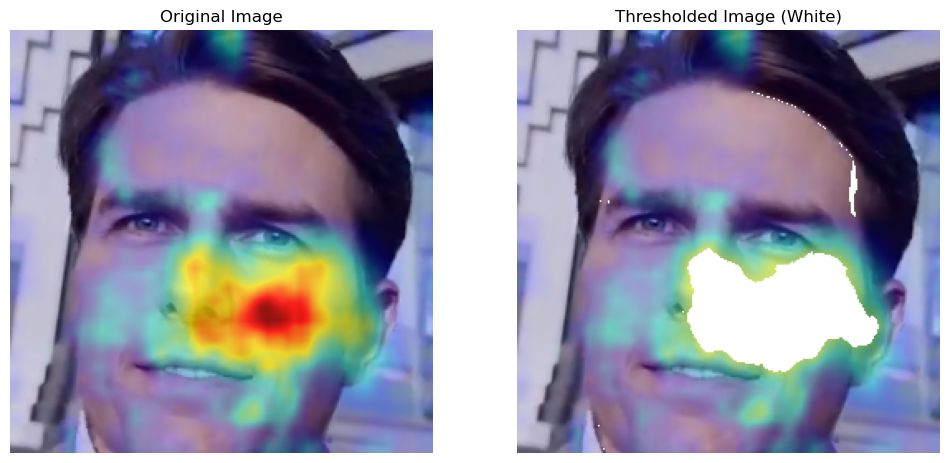

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define new threshold values
red_threshold = 100
non_red_threshold = 100

# Define white color in BGR format
highlight_color = (255, 255, 255)  # OpenCV uses BGR order

# Load the image
image_path = "image.png"
image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found. Check the file path.")

# Convert to RGB for visualization
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split channels
blue_channel, green_channel, red_channel = cv2.split(image)

# Apply masks with new threshold (100)
red_mask = (red_channel >= red_threshold) & (blue_channel <= non_red_threshold) & (green_channel <= non_red_threshold)

orange_mask = (red_channel >= 100) & (green_channel >= 100) & (green_channel <= 200) & (blue_channel <= 100)

yellow_mask = (red_channel >= 100) & (green_channel >= 100) & (blue_channel <= 100)

# Combine masks
combined_mask = red_mask | orange_mask | yellow_mask

# Create an output image initialized as a copy of the original
output_image = image_rgb.copy()

# Apply white to the relevant pixels
output_image[combined_mask] = highlight_color  # RGB format

# Display the original and processed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(output_image)
ax[1].set_title("Thresholded Image (White)")
ax[1].axis("off")

plt.show()
